In [1]:
## Table & Visualization Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import pickle
import json

## Prediction Libraries
from sklearn.metrics import classification_report, confusion_matrix, \
accuracy_score, plot_confusion_matrix, auc, roc_curve

## Cross-Validation Libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

## Model Libraries
from sklearn.tree import DecisionTreeClassifier

In [2]:
## Change this to your new training data
df = pd.read_csv("df_cleaned.csv")
df = df.drop_duplicates(subset='website')

In [3]:
df.head()

,Unnamed: 0,merchant_name,broken_link_score,link_contact_us_exist,cu_email_exist,cu_phone_number_exist,link_about_us_exist,link_tnc_exist,tnc_refund_policy_exist,contact_us_score,tnc_score,links_response,website,fraud_score,label
0,0,CV.ASIATRIPINDONESIA,0.000000,1.0,1.0,1.0,0.0,1.0,1.0,100.0,100.0,{'https://asiatrip.id/reseller/': '<Response [...,http://asiatrip.id/,0.000000,APPROVED
1,1,Pt.BloomingLotusYoga,70.000000,1.0,1.0,1.0,1.0,1.0,1.0,100.0,100.0,{'http://www.blooming-lotus-yoga.com/bliss-mag...,https://www.blooming-lotus-yoga.com,0.000000,APPROVED
2,2,YayasanGreenSejahtera,11.111111,1.0,1.0,1.0,1.0,1.0,1.0,100.0,100.0,"{'': 'No Response/Timeout', 'https://greenseja...",https://greensejahterafoundation.com/,0.000000,APPROVED
3,3,PTMatairTerraSolusi,12.500000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"{'': 'No Response/Timeout', 'https://www.matai...",http://www.matair.co.id,0.666667,APPROVED
4,4,SimplyMii,0.000000,1.0,1.0,1.0,0.0,0.0,0.0,100.0,0.0,{'https://www.simplymii.com/products/category/...,https://www.simplymii.com/,0.000000,APPROVED


In [4]:
df.groupby("label").size()

label
APPROVED    215
REJECTED     77
dtype: int64

In [5]:
df.shape

(292, 15)

In [6]:
y = df['label'].apply(lambda x: 1 if x == 'REJECTED' else 0)

In [7]:
X = df.iloc[:, 2:9]

## Train/Test Split

In [8]:
X.head(1)

,broken_link_score,link_contact_us_exist,cu_email_exist,cu_phone_number_exist,link_about_us_exist,link_tnc_exist,tnc_refund_policy_exist
0,0.0,1.0,1.0,1.0,0.0,1.0,1.0


In [9]:
## Binarize broken_link_score, with threshold 50.0
X["broken_link_score"] = (X["broken_link_score"] < 50.0)

In [10]:
for col in X:
    X[col] = X[col].astype(int)

In [11]:
X['broken_link_score']

0      1
1      0
2      1
3      1
4      1
      ..
435    0
436    1
437    0
438    0
440    0
Name: broken_link_score, Length: 292, dtype: int64

In [12]:
X.shape

(292, 7)

In [13]:
X.columns

Index(['broken_link_score', 'link_contact_us_exist', 'cu_email_exist',
       'cu_phone_number_exist', 'link_about_us_exist', 'link_tnc_exist',
       'tnc_refund_policy_exist'],
      dtype='object')

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [15]:
model_choice = DecisionTreeClassifier()

In [16]:
clf = model_choice
clf = clf.fit(X_train, y_train)

In [17]:
## Using the best TPR threshold
# y_pred = (clf.predict_proba(X_test)[:,1] >= 0.7367280663362746).astype(bool)

In [18]:
## Using the default threshold == 0.5
y_pred = clf.predict(X_test)

In [19]:
y_pred_proba = clf.predict_proba(X_test)

In [20]:
np.round(accuracy_score(y_test, y_pred), 2)

0.85

In [21]:
y_train.value_counts(), y_test.value_counts()

(0    141
 1     54
 Name: label, dtype: int64,
 0    74
 1    23
 Name: label, dtype: int64)

In [22]:
## Confusion matrix with best TPR threshold
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [23]:
tpr, fpr = np.round((tp/(tp+fn), fp/(fp+tn)), 3)
## TPR = Dari semua REJECTED merchant berapa % yang berhasil kereject, 
## FPR = Dari semua APPROVED berapa % yang kita salah tebak sebagai REJECTED
## This rate applies to a default threshold of 0.5
tpr, fpr

(0.783, 0.135)

In [24]:
tn, fp, fn, tp

(64, 10, 5, 18)

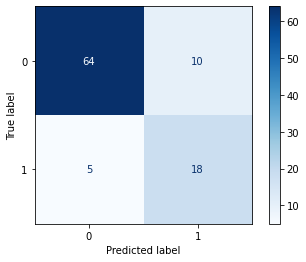

In [25]:
## This matrix visualization is based on 0.5 threshold
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

In [26]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

In [27]:
auc_score = auc(fpr, tpr)

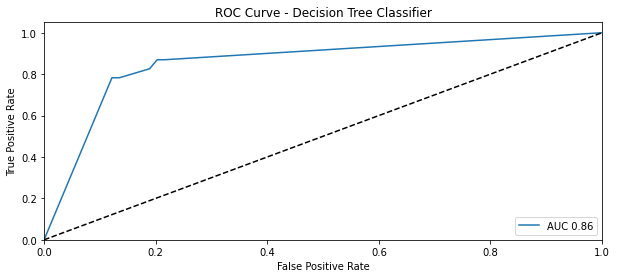

In [28]:
plt.figure(figsize=(10,4))
plt.plot(fpr, tpr, label='AUC %0.2f' % (auc_score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree Classifier')
plt.legend(loc="lower right")

# # find optimum thresholds
# i = np.arange(len(tpr)) # index for df
# roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i).apply(lambda x: x), 'thresholds' : pd.Series(thresholds, index = i)})
# df_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

# plt.plot(df_thresh['fpr'], df_thresh['tpr'], marker='o', markersize=8, color='darkred')

# # create the axis of thresholds (scores)
# ax2 = plt.gca().twinx()
# ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='darkred')
# ax2.set_ylabel('Threshold',color='darkred')
# ax2.set_ylim([thresholds[-1],thresholds[0]])
# ax2.set_xlim([fpr[0],fpr[-1]])
# ax2.plot(df_thresh['fpr'], df_thresh['thresholds'], marker='o', markersize=8, color='darkred')


plt.show()
# print(" -- Optimum Threshold -- ")
# print(df_thresh)

In [29]:
print("-- Best TPR Threshold -- ")
## Finding threshold where TPR > Optimum TPR but FPR stays below 15%
for i in range(len(fpr)):
#     if tpr[i] > 0.85 and fpr[i] < 0.20:
        print("TPR %s, FPR %s, Threshold %s" % (tpr[i], fpr[i], thresholds[i]))

-- Best TPR Threshold -- 
TPR 0.0, FPR 0.0, Threshold 2.0
TPR 0.782608695652174, FPR 0.12162162162162163, Threshold 1.0
TPR 0.782608695652174, FPR 0.13513513513513514, Threshold 0.6666666666666666
TPR 0.8260869565217391, FPR 0.1891891891891892, Threshold 0.5
TPR 0.8695652173913043, FPR 0.20270270270270271, Threshold 0.42857142857142855
TPR 0.8695652173913043, FPR 0.21621621621621623, Threshold 0.3333333333333333
TPR 1.0, FPR 1.0, Threshold 0.0


## Bootstrapped

In [30]:
accuracy_list = []
auc_list = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=i)
    clf = model_choice
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])
    auc_score = auc(fpr, tpr)
    
    accuracy_list.append(accuracy)
    auc_list.append(auc_score)
    print("Iteration %s: AUC:%s, Accuracy:%s" % (i, auc_score, accuracy))

Iteration 0: AUC:0.9130555555555555, Accuracy:0.8865979381443299
Iteration 1: AUC:0.8359533468559837, Accuracy:0.8041237113402062
Iteration 2: AUC:0.8704465334900118, Accuracy:0.8556701030927835
Iteration 3: AUC:0.8692922374429224, Accuracy:0.865979381443299
Iteration 4: AUC:0.8112134344528711, Accuracy:0.865979381443299
Iteration 5: AUC:0.8637566137566137, Accuracy:0.8247422680412371
Iteration 6: AUC:0.8853365384615384, Accuracy:0.865979381443299
Iteration 7: AUC:0.8630555555555556, Accuracy:0.8350515463917526
Iteration 8: AUC:0.7968036529680365, Accuracy:0.8041237113402062
Iteration 9: AUC:0.8678025851938896, Accuracy:0.865979381443299
Iteration 10: AUC:0.8985507246376812, Accuracy:0.845360824742268
Iteration 11: AUC:0.8260649087221096, Accuracy:0.8247422680412371
Iteration 12: AUC:0.8592592592592593, Accuracy:0.8865979381443299
Iteration 13: AUC:0.8531746031746033, Accuracy:0.8144329896907216
Iteration 14: AUC:0.8430365296803652, Accuracy:0.8350515463917526
Iteration 15: AUC:0.76029

Iteration 143: AUC:0.7683333333333333, Accuracy:0.7628865979381443
Iteration 144: AUC:0.7993537015276146, Accuracy:0.8041237113402062
Iteration 145: AUC:0.7884615384615384, Accuracy:0.8144329896907216
Iteration 146: AUC:0.7776369168356998, Accuracy:0.8144329896907216
Iteration 147: AUC:0.8071946169772256, Accuracy:0.8041237113402062
Iteration 148: AUC:0.8714488636363636, Accuracy:0.865979381443299
Iteration 149: AUC:0.7806795131845842, Accuracy:0.8144329896907216
Iteration 150: AUC:0.8248987854251012, Accuracy:0.845360824742268
Iteration 151: AUC:0.8786057692307692, Accuracy:0.845360824742268
Iteration 152: AUC:0.8393066980023502, Accuracy:0.845360824742268
Iteration 153: AUC:0.8515981735159819, Accuracy:0.8350515463917526
Iteration 154: AUC:0.7775132275132275, Accuracy:0.8350515463917526
Iteration 155: AUC:0.8100414078674948, Accuracy:0.8144329896907216
Iteration 156: AUC:0.8304232804232804, Accuracy:0.865979381443299
Iteration 157: AUC:0.8469664138678223, Accuracy:0.8556701030927835


Iteration 297: AUC:0.8047222222222222, Accuracy:0.8556701030927835
Iteration 298: AUC:0.7477611940298508, Accuracy:0.8144329896907216
Iteration 299: AUC:0.8818181818181818, Accuracy:0.865979381443299
Iteration 300: AUC:0.8141821946169772, Accuracy:0.8144329896907216
Iteration 301: AUC:0.8363636363636364, Accuracy:0.8247422680412371
Iteration 302: AUC:0.8326110509209101, Accuracy:0.845360824742268
Iteration 303: AUC:0.8577922077922078, Accuracy:0.8247422680412371
Iteration 304: AUC:0.8655844155844156, Accuracy:0.8865979381443299
Iteration 305: AUC:0.9241854636591478, Accuracy:0.8556701030927835
Iteration 306: AUC:0.8117897727272728, Accuracy:0.8144329896907216
Iteration 307: AUC:0.7993537015276145, Accuracy:0.8350515463917526
Iteration 308: AUC:0.8851351351351352, Accuracy:0.8969072164948454
Iteration 309: AUC:0.7616459627329193, Accuracy:0.845360824742268
Iteration 310: AUC:0.8696969696969696, Accuracy:0.865979381443299
Iteration 311: AUC:0.8424242424242424, Accuracy:0.8247422680412371

Iteration 451: AUC:0.8314814814814815, Accuracy:0.8556701030927835
Iteration 452: AUC:0.8425456389452332, Accuracy:0.8350515463917526
Iteration 453: AUC:0.8372156013001083, Accuracy:0.8350515463917526
Iteration 454: AUC:0.8758561643835616, Accuracy:0.8865979381443299
Iteration 455: AUC:0.836111111111111, Accuracy:0.8144329896907216
Iteration 456: AUC:0.7883675464320624, Accuracy:0.8041237113402062
Iteration 457: AUC:0.8072222222222222, Accuracy:0.8556701030927835
Iteration 458: AUC:0.8366666666666667, Accuracy:0.8762886597938144
Iteration 459: AUC:0.781947261663286, Accuracy:0.7835051546391752
Iteration 460: AUC:0.8619271445358402, Accuracy:0.865979381443299
Iteration 461: AUC:0.8336405529953916, Accuracy:0.8144329896907216
Iteration 462: AUC:0.7650793650793649, Accuracy:0.8041237113402062
Iteration 463: AUC:0.8616333725029377, Accuracy:0.8350515463917526
Iteration 464: AUC:0.8726708074534161, Accuracy:0.8865979381443299
Iteration 465: AUC:0.911764705882353, Accuracy:0.8350515463917526

Iteration 607: AUC:0.916305525460455, Accuracy:0.8865979381443299
Iteration 608: AUC:0.9352777777777779, Accuracy:0.865979381443299
Iteration 609: AUC:0.8452777777777777, Accuracy:0.845360824742268
Iteration 610: AUC:0.8483333333333334, Accuracy:0.865979381443299
Iteration 611: AUC:0.8944805194805194, Accuracy:0.8865979381443299
Iteration 612: AUC:0.8708592132505176, Accuracy:0.865979381443299
Iteration 613: AUC:0.9069696969696971, Accuracy:0.8556701030927835
Iteration 614: AUC:0.8743228602383533, Accuracy:0.8865979381443299
Iteration 615: AUC:0.8548085901027076, Accuracy:0.8144329896907216
Iteration 616: AUC:0.8835820895522388, Accuracy:0.845360824742268
Iteration 617: AUC:0.8496753246753248, Accuracy:0.845360824742268
Iteration 618: AUC:0.8651586368977673, Accuracy:0.8350515463917526
Iteration 619: AUC:0.8529252437703142, Accuracy:0.8144329896907216
Iteration 620: AUC:0.8815639269406392, Accuracy:0.8762886597938144
Iteration 621: AUC:0.8190682556879739, Accuracy:0.845360824742268
Ite

Iteration 764: AUC:0.8748645720476707, Accuracy:0.865979381443299
Iteration 765: AUC:0.8799171842650103, Accuracy:0.8247422680412371
Iteration 766: AUC:0.8922222222222221, Accuracy:0.865979381443299
Iteration 767: AUC:0.8986872146118721, Accuracy:0.8762886597938144
Iteration 768: AUC:0.8094444444444444, Accuracy:0.8144329896907216
Iteration 769: AUC:0.8558333333333333, Accuracy:0.8556701030927835
Iteration 770: AUC:0.8462854349951124, Accuracy:0.8247422680412371
Iteration 771: AUC:0.9047619047619049, Accuracy:0.865979381443299
Iteration 772: AUC:0.806338028169014, Accuracy:0.8350515463917526
Iteration 773: AUC:0.85, Accuracy:0.845360824742268
Iteration 774: AUC:0.8851515151515152, Accuracy:0.845360824742268
Iteration 775: AUC:0.8388888888888888, Accuracy:0.8350515463917526
Iteration 776: AUC:0.8198808234019501, Accuracy:0.8762886597938144
Iteration 777: AUC:0.8283208020050125, Accuracy:0.8350515463917526
Iteration 778: AUC:0.7518959913326111, Accuracy:0.8041237113402062
Iteration 779: 

Iteration 920: AUC:0.7431541582150101, Accuracy:0.7628865979381443
Iteration 921: AUC:0.8438416422287389, Accuracy:0.845360824742268
Iteration 922: AUC:0.9142424242424243, Accuracy:0.8865979381443299
Iteration 923: AUC:0.8559837728194726, Accuracy:0.8144329896907216
Iteration 924: AUC:0.8489736070381231, Accuracy:0.8247422680412371
Iteration 925: AUC:0.8350746268656717, Accuracy:0.8350515463917526
Iteration 926: AUC:0.9032091097308489, Accuracy:0.8556701030927835
Iteration 927: AUC:0.8807077625570776, Accuracy:0.8144329896907216
Iteration 928: AUC:0.8747464503042596, Accuracy:0.845360824742268
Iteration 929: AUC:0.8940092165898619, Accuracy:0.8865979381443299
Iteration 930: AUC:0.8139303482587064, Accuracy:0.8144329896907216
Iteration 931: AUC:0.8111940298507463, Accuracy:0.8350515463917526
Iteration 932: AUC:0.8391666666666666, Accuracy:0.8556701030927835
Iteration 933: AUC:0.8442424242424242, Accuracy:0.8041237113402062
Iteration 934: AUC:0.8663636363636364, Accuracy:0.86597938144329

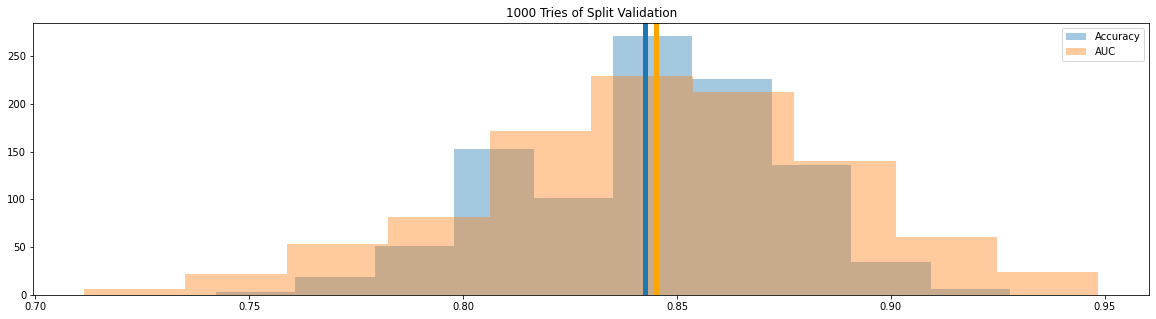

Accuracy mean: 0.84
AUC mean: 0.85


In [31]:
plt.figure(figsize=(20,5))
plt.title("1000 Tries of Split Validation")
sns.distplot(accuracy_list, bins=10, label = 'Accuracy', kde=False)
sns.distplot(auc_list, bins=10, label = 'AUC', kde=False)
plt.axvline(x=pd.Series(accuracy_list).mean(), lw=5)
plt.axvline(x=pd.Series(auc_list).mean(), lw=5, color='orange')
plt.legend()
plt.show()
print("Accuracy mean: %0.2f" % pd.Series(accuracy_list).mean())
print("AUC mean: %0.2f" % pd.Series(auc_list).mean())

## Cross Validation & Hyperparameter Tuning

#### Process

In [32]:
## Hyperparameters
max_depth = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
min_samples_split = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model_choice = DecisionTreeClassifier(random_state=0)

In [34]:
kfold = StratifiedKFold(n_splits=5)
cv_results = cross_val_score(model_choice, X_train, y_train, cv=kfold, scoring='roc_auc')

In [35]:
cv_results

array([0.83116883, 0.72564935, 0.75162338, 0.89448052, 0.97931034])

In [36]:
## Get the best fold train data to be tested on dataset B
i = 0
idx_train_best = []
idx_test_best = []
for train, test in kfold.split(X_train, y_train):
    if i == np.argmax(cv_results):
        idx_train_best = train
        idx_test_best = test
    i += 1

In [37]:
X_train_best = X_train.reset_index().iloc[idx_train_best].drop("index", axis=1)
y_train_best = y_train.reset_index().iloc[idx_train_best].drop("index", axis=1)

In [38]:
X_test_best = X_train.reset_index().iloc[idx_test_best].drop("index", axis=1)
y_test_best = y_train.reset_index().iloc[idx_test_best].drop("index", axis=1)

In [39]:
clf = model_choice.fit(X_train_best, y_train_best)
y_best_proba = clf.predict_proba(X_test_best)
fpr, tpr, thresholds = roc_curve(y_test_best, y_best_proba[:,1])
auc_score = auc(fpr, tpr)
## Check its the same as cv_results
auc_score

0.9793103448275862

In [40]:
## Test the best fold to dataset B
clf = model_choice.fit(X_train_best, y_train_best)
y_test_proba = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])
auc_score = auc(fpr, tpr)
## Check the AUC on dataset B
auc_score

0.8572267920094007

#### Calculate Results

In [41]:
## Results
best_fold = []
best_fold_auc = []
dataset_b_auc = []
depths = []
samples_split = []
idx_train_data = []

## Hyperparameters
max_depth = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
min_samples_split = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75]

## Split the data to dataset A (train) and dataset B (test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Split dataset A (train) to 5 folds
kfold = StratifiedKFold(n_splits=5)

for i in range(len(max_depth)):
    for j in range(len(min_samples_split)):
        
        ## Fit the params
        model_choice = DecisionTreeClassifier\
        (random_state=0, max_depth=max_depth[i], min_samples_split=min_samples_split[j])

        ## Do cross validation
        cv_results = cross_val_score(model_choice, X_train, y_train, cv=kfold, scoring='roc_auc')

        ## Get the index best fold train data to be tested on dataset B
        idx = 0
        idx_train_best = []
        idx_test_best = []
        for train, test in kfold.split(X_train, y_train):
            if idx == np.argmax(cv_results):
                idx_train_best = train
                idx_test_best = test
            idx += 1

        ## Get the best fold train and test data
        X_train_best = X_train.reset_index().iloc[idx_train_best].drop("index", axis=1)
        y_train_best = y_train.reset_index().iloc[idx_train_best].drop("index", axis=1)

        X_test_best = X_train.reset_index().iloc[idx_test_best].drop("index", axis=1)
        y_test_best = y_train.reset_index().iloc[idx_test_best].drop("index", axis=1)

        ## Fit the model with the best fold data
        clf = model_choice.fit(X_train_best, y_train_best)

        ## Test the best fold to dataset B
        ## Check the AUC on dataset B
        y_test_proba = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])
        auc_score = auc(fpr, tpr)
        
        best_fold.append(np.argmax(cv_results)+1)
        best_fold_auc.append(np.max(cv_results))
        dataset_b_auc.append(auc_score)
        depths.append(max_depth[i])
        samples_split.append(min_samples_split[j])
        idx_train_data.append(idx_train_best)
        
        print("Max Depth: %s, Min. Sample Split: %s, Best Fold AUC: %s (Fold %s), Dataset B AUC: %s" \
              % (max_depth[i], min_samples_split[j], np.max(cv_results), np.argmax(cv_results)+1, auc_score))

Max Depth: 1, Min. Sample Split: 5, Best Fold AUC: 0.9310344827586207 (Fold 5), Dataset B AUC: 0.7928907168037602
Max Depth: 1, Min. Sample Split: 10, Best Fold AUC: 0.9310344827586207 (Fold 5), Dataset B AUC: 0.7928907168037602
Max Depth: 1, Min. Sample Split: 15, Best Fold AUC: 0.9310344827586207 (Fold 5), Dataset B AUC: 0.7928907168037602
Max Depth: 1, Min. Sample Split: 20, Best Fold AUC: 0.9310344827586207 (Fold 5), Dataset B AUC: 0.7928907168037602
Max Depth: 1, Min. Sample Split: 25, Best Fold AUC: 0.9310344827586207 (Fold 5), Dataset B AUC: 0.7928907168037602
Max Depth: 1, Min. Sample Split: 30, Best Fold AUC: 0.9310344827586207 (Fold 5), Dataset B AUC: 0.7928907168037602
Max Depth: 1, Min. Sample Split: 35, Best Fold AUC: 0.9310344827586207 (Fold 5), Dataset B AUC: 0.7928907168037602
Max Depth: 1, Min. Sample Split: 40, Best Fold AUC: 0.9310344827586207 (Fold 5), Dataset B AUC: 0.7928907168037602
Max Depth: 1, Min. Sample Split: 45, Best Fold AUC: 0.9310344827586207 (Fold 5), 

Max Depth: 5, Min. Sample Split: 65, Best Fold AUC: 0.9496753246753246 (Fold 4), Dataset B AUC: 0.913924794359577
Max Depth: 5, Min. Sample Split: 70, Best Fold AUC: 0.9310344827586207 (Fold 5), Dataset B AUC: 0.8307873090481785
Max Depth: 5, Min. Sample Split: 75, Best Fold AUC: 0.9310344827586207 (Fold 5), Dataset B AUC: 0.8307873090481785
Max Depth: 6, Min. Sample Split: 5, Best Fold AUC: 0.9620689655172414 (Fold 5), Dataset B AUC: 0.8569330199764982
Max Depth: 6, Min. Sample Split: 10, Best Fold AUC: 0.963793103448276 (Fold 5), Dataset B AUC: 0.9315511163337251
Max Depth: 6, Min. Sample Split: 15, Best Fold AUC: 0.9689655172413794 (Fold 5), Dataset B AUC: 0.9550528789659225
Max Depth: 6, Min. Sample Split: 20, Best Fold AUC: 0.9586206896551724 (Fold 5), Dataset B AUC: 0.9582843713278495
Max Depth: 6, Min. Sample Split: 25, Best Fold AUC: 0.9758620689655173 (Fold 5), Dataset B AUC: 0.9391891891891893
Max Depth: 6, Min. Sample Split: 30, Best Fold AUC: 0.9758620689655173 (Fold 5), Da

Max Depth: 10, Min. Sample Split: 50, Best Fold AUC: 0.9517241379310345 (Fold 5), Dataset B AUC: 0.9068742655699178
Max Depth: 10, Min. Sample Split: 55, Best Fold AUC: 0.9517241379310345 (Fold 5), Dataset B AUC: 0.9068742655699178
Max Depth: 10, Min. Sample Split: 60, Best Fold AUC: 0.9517241379310345 (Fold 5), Dataset B AUC: 0.9068742655699178
Max Depth: 10, Min. Sample Split: 65, Best Fold AUC: 0.9496753246753246 (Fold 4), Dataset B AUC: 0.913924794359577
Max Depth: 10, Min. Sample Split: 70, Best Fold AUC: 0.9310344827586207 (Fold 5), Dataset B AUC: 0.8307873090481785
Max Depth: 10, Min. Sample Split: 75, Best Fold AUC: 0.9310344827586207 (Fold 5), Dataset B AUC: 0.8307873090481785
Max Depth: 11, Min. Sample Split: 5, Best Fold AUC: 0.9655172413793103 (Fold 5), Dataset B AUC: 0.858108108108108
Max Depth: 11, Min. Sample Split: 10, Best Fold AUC: 0.963793103448276 (Fold 5), Dataset B AUC: 0.9315511163337251
Max Depth: 11, Min. Sample Split: 15, Best Fold AUC: 0.9689655172413794 (Fol

Max Depth: 15, Min. Sample Split: 40, Best Fold AUC: 0.9517241379310345 (Fold 5), Dataset B AUC: 0.9068742655699178
Max Depth: 15, Min. Sample Split: 45, Best Fold AUC: 0.9517241379310345 (Fold 5), Dataset B AUC: 0.9068742655699178
Max Depth: 15, Min. Sample Split: 50, Best Fold AUC: 0.9517241379310345 (Fold 5), Dataset B AUC: 0.9068742655699178
Max Depth: 15, Min. Sample Split: 55, Best Fold AUC: 0.9517241379310345 (Fold 5), Dataset B AUC: 0.9068742655699178
Max Depth: 15, Min. Sample Split: 60, Best Fold AUC: 0.9517241379310345 (Fold 5), Dataset B AUC: 0.9068742655699178
Max Depth: 15, Min. Sample Split: 65, Best Fold AUC: 0.9496753246753246 (Fold 4), Dataset B AUC: 0.913924794359577
Max Depth: 15, Min. Sample Split: 70, Best Fold AUC: 0.9310344827586207 (Fold 5), Dataset B AUC: 0.8307873090481785
Max Depth: 15, Min. Sample Split: 75, Best Fold AUC: 0.9310344827586207 (Fold 5), Dataset B AUC: 0.8307873090481785


In [42]:
df_result = pd.DataFrame({"max_depth": depths, "min_samples_split": samples_split, "fold_index": best_fold, \
                          "best_fold_auc": best_fold_auc, "test_auc": dataset_b_auc, "train_idx": idx_train_data})
df_result.head()

,max_depth,min_samples_split,fold_index,best_fold_auc,test_auc,train_idx
0,1,5,5,0.931034,0.792891,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,1,10,5,0.931034,0.792891,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,1,15,5,0.931034,0.792891,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3,1,20,5,0.931034,0.792891,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
4,1,25,5,0.931034,0.792891,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [43]:
df_result[df_result.test_auc == df_result.test_auc.min()].iloc[:,:-1].head()

,max_depth,min_samples_split,fold_index,best_fold_auc,test_auc
0,1,5,5,0.931034,0.792891
1,1,10,5,0.931034,0.792891
2,1,15,5,0.931034,0.792891
3,1,20,5,0.931034,0.792891
4,1,25,5,0.931034,0.792891


In [44]:
df_result[df_result.test_auc == df_result.test_auc.max()].iloc[:,:-1].head()

,max_depth,min_samples_split,fold_index,best_fold_auc,test_auc
48,4,20,5,0.958621,0.958284
63,5,20,5,0.958621,0.958284
78,6,20,5,0.958621,0.958284
93,7,20,5,0.958621,0.958284
108,8,20,5,0.958621,0.958284


In [45]:
best_idx = df_result[df_result.test_auc == df_result.test_auc.max()]['train_idx'].iloc[0]
best_max_depth = df_result[df_result.test_auc == df_result.test_auc.max()]['max_depth'].iloc[0]
best_min_samples_split = df_result[df_result.test_auc == df_result.test_auc.max()]['min_samples_split'].iloc[0]

In [46]:
## Calculating the metrics for the best AUC params
X_train_chosen = X_train.reset_index().iloc[best_idx].drop("index", axis=1)
y_train_chosen = y_train.reset_index().iloc[best_idx].drop("index", axis=1)

In [47]:
clf = DecisionTreeClassifier\
        (random_state=0, max_depth=best_max_depth, min_samples_split=best_min_samples_split)

In [48]:
clf.fit(X_train_chosen, y_train_chosen)
y_test_proba = clf.predict_proba(X_test)
y_test_predict = clf.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])
auc_score = auc(fpr, tpr)
accuracy = accuracy_score(y_test, y_test_predict)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_predict).ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

In [49]:
print("AUC: %.3f" % auc_score)
print("Accuracy: %.3f " % accuracy)
print("Precision: %.3f " % precision)
print("Recall: %.3f " % recall)
print("F1 Score: %.3f " % f1_score)

AUC: 0.958
Accuracy: 0.907 
Precision: 0.818 
Recall: 0.783 
F1 Score: 0.800 


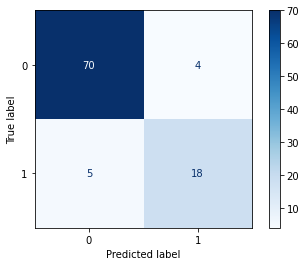

In [50]:
## This matrix visualization is based on 0.5 threshold
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

In [51]:
print("True Positive: %s" % tp)
print("False Positive: %s" % fp)
print("True Negative: %s" % tn)
print("False Negative: %s" % fn)

True Positive: 18
False Pasitive: 4
True Negative: 70
False Negative: 5


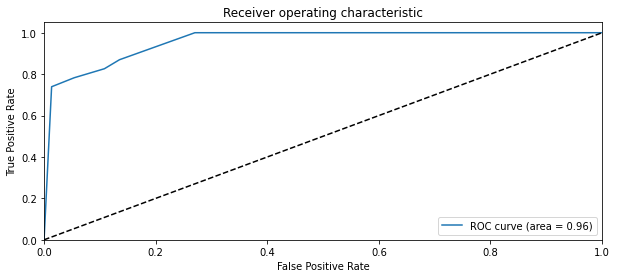

In [52]:
plt.figure(figsize=(10,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (auc_score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

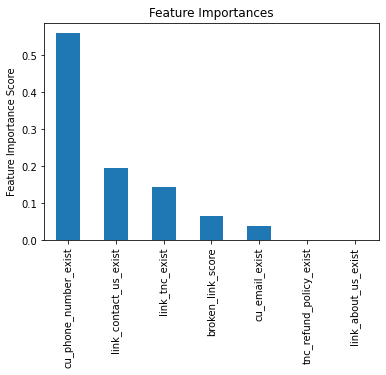

In [65]:
## Calculate feature importance by compute the (normalized) total reduction of the criterion brought by that feature
## Also known as Gini Importance
feat_score = clf.tree_.compute_feature_importances()
feat_name = X_train_chosen.columns.values

feat_imp = pd.Series(index=feat_name, data=feat_score).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()

## Dump To Pickle

In [53]:
# clf = model_choice
# clf = clf.fit(X, y)
# pickle.dump(clf, open('../models/final_prediction.pickle', 'wb'))

In [54]:
# feat_imp = pd.Series(clf.get_booster().get_fscore()).sort_values(ascending=False)
# feat_imp.plot(kind='bar', title='Feature Importances')
# plt.ylabel('Feature Importance Score')
# plt.show()